# Modeling and Optimizing Temporary Market Impact in Equity Trading

By Amos Anderson

> This notebook is a compliment to the write up file `Modeling Temporary Impact Function PDF.pdf`. Please refer to the pdf for various derivations.

In [96]:
# necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from numpy import exp, log, sqrt
from datetime import datetime
from scipy.optimize import curve_fit

## Data Preprocessing

We aggregate all CSV files for each stock into 390 one-minute snapshots. We also check for missing data, and handle missing values in such a way that does not introduce bias in our analysis.

In [94]:
# ticker file loader function
def load_all_csvs(ticker_folder_path):
    ticker_data = []

    for file in os.listdir(ticker_folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(ticker_folder_path, file)
            df = pd.read_csv(file_path)

            # Cleaning column names
            df.columns = [col.strip() for col in df.columns]

            # Computing mid price
            df['mid_price'] = (df['ask_px_00'] + df['bid_px_00']) / 2

            # Parsing datetime to format used in dataset
            df['ts_event'] = pd.to_datetime(df['ts_event'], format='ISO8601', errors='coerce', utc=True)

            # Resampling to 1-min snapshots to match N=390
            df.set_index('ts_event', inplace=True)
            df = df.resample('1Min').first().reset_index()

            ticker_data.append(df)

    return pd.concat(ticker_data, ignore_index=True)

In [45]:
# Folder paths
soun_folder = r"C:\Users\amosa\Documents\My Graduate School\SPIR Internship\BlockHouse_Quant Research Intern\Datasets\SOUN"
frog_folder = r"C:\Users\amosa\Documents\My Graduate School\SPIR Internship\BlockHouse_Quant Research Intern\Datasets\FROG"
crww_folder = r"C:\Users\amosa\Documents\My Graduate School\SPIR Internship\BlockHouse_Quant Research Intern\Datasets\CRWV"

# Loading ticker data
soun_data = load_all_csvs(soun_folder)
frog_data = load_all_csvs(frog_folder)
crww_data = load_all_csvs(crww_folder)

print(soun_data.shape)
print(frog_data.shape)
print(crww_data.shape)

(8190, 75)
(8190, 75)
(8190, 75)


The output above is right because if we take any stock data for instance and resample it so that N=390 per day, then for all 21 days in the given data, we expect $$21 \times 390 = 8190 \quad \text{rows}$$

In [46]:
# checking for missing values
print(soun_data.isnull().sum())
print(frog_data.isnull().sum())
print(crww_data.isnull().sum())

ts_event         0
ts_event.1       0
rtype            0
publisher_id     0
instrument_id    0
                ..
ask_sz_09        0
bid_ct_09        0
ask_ct_09        0
symbol           0
mid_price        0
Length: 75, dtype: int64
ts_event          0
ts_event.1       28
rtype            28
publisher_id     28
instrument_id    28
                 ..
ask_sz_09        28
bid_ct_09        28
ask_ct_09        28
symbol           28
mid_price        28
Length: 75, dtype: int64
ts_event         0
ts_event.1       1
rtype            1
publisher_id     1
instrument_id    1
                ..
ask_sz_09        1
bid_ct_09        1
ask_ct_09        1
symbol           1
mid_price        1
Length: 75, dtype: int64


A thorough analysis ought to be conducted to find out whether the missing values are Missing Completely at Random (MCAR) or Missing not at Random (MNAR) as the type of missing value would influence our approach in handling it.

If we choose to drop the missing values, we reduce data volume and risk possibly losing important dynamics. If we decide to fill in the missing data, we risk biasing the slippage curves.

For the purpose of modeling temporary impact in this project, we adopt a conservative approach by restricting our analysis to only those data points where all required columns contain valid (non-missing) values. This ensures that our estimates of market impact are based solely on observed, reliable limit order book snapshots, without introducing assumptions through imputation.

In [47]:
soun_clean = soun_data.dropna(subset=['ts_event', 'mid_price', 'ask_px_00', 'bid_px_00'])
frog_clean = frog_data.dropna(subset=['ts_event', 'mid_price', 'ask_px_00', 'bid_px_00'])
crww_clean = crww_data.dropna(subset=['ts_event', 'mid_price', 'ask_px_00', 'bid_px_00'])

print(soun_clean.shape)
print(frog_clean.shape)
print(crww_clean.shape)

(8190, 75)
(8162, 75)
(8189, 75)


## Modeling the Temporary Impact Function

### Definition
The temporary impact function $g_t(X)$ is defined as the slippage per share for a buy market order of $X$ shares at time $t$, for each of the 390 one-minute periods of each stock. It is given by
$$g_t(X) = \frac{\sum_{i=0}^{k-1} q_{t,i}\cdot p_{t,i} + \left(X - \sum_{i=0}^{k-1} q_{t,i}\right)\cdot p_{t,k} }{X} - m_t $$
where:

- $p_{t,i}$: Ask prices (ask_px_00 to ask_px_09) at time $ t $. 
  
- $q_{t,i} $: Ask quantities (ask_sz_00 to ask_sz_09) at time $ t $. 

- $k$: Smallest index such that $ \sum_{i=0}^k q_{t,i} \geq X $. 

- $m_t$: Mid-price, $ \frac{\text{bid\_px\_00}_t + \text{ask\_px\_00}_t}{2} $.

[See write-up for derivation]

In [52]:
# temporary impact function
def temporary_impact_function(X_shares, ask_prices, ask_sizes, mid_price):
    """
    Compute the temporary market impact g_t(X) for a buy market order of X_shares.
    
    Parameters:
        X_shares (float): size of the market order
        ask_prices (list or array): ask_px_00 to ask_px_09
        ask_sizes (list or array): ask_sz_00 to ask_sz_09
        mid_price (float): current mid-price
    
    Returns:
        float: g_t(X) = average slippage per share
    """
    cum_sizes = 0.0
    total_cost = 0.0
    
    for i in range(len(ask_prices)):
        if cum_sizes + ask_sizes[i] >= X_shares:
            X_remaining = X_shares - cum_sizes
            total_cost += X_remaining * ask_prices[i]
            break
        else:
            total_cost += ask_sizes[i] * ask_prices[i]
            cum_sizes += ask_sizes[i]

    return total_cost / X_shares - mid_price

In [54]:
# Compute g_t(X) for a fixed order size
def compute_temp_impact(row, X_shares=100, levels=10):
    ask_prices = np.array([row[f"ask_px_{i:02d}"] for i in range(levels)])
    ask_sizes  = np.array([row[f"ask_sz_{i:02d}"] for i in range(levels)])
    mid_price  = row['mid_price']
    
    return temporary_impact_function(X_shares, ask_prices, ask_sizes, mid_price)

In [95]:
# Example: Consider SOUN, X = 100 shares
soun_clean_100shares = soun_clean.apply(lambda row: compute_temp_impact(row, X_shares=100), axis=1)
soun_clean_100shares

0       0.010
1       0.015
2       0.005
3       0.015
4       0.010
        ...  
8185    0.005
8186    0.005
8187    0.005
8188    0.005
8189    0.005
Length: 8190, dtype: float64

## Empirical Analysis on Temporary Impact Function

### Sample Visualization of Temporary Impact Curve

To analyse the behaviour of the temporary impact function, we fix a timestamp and visualize the slippage. 

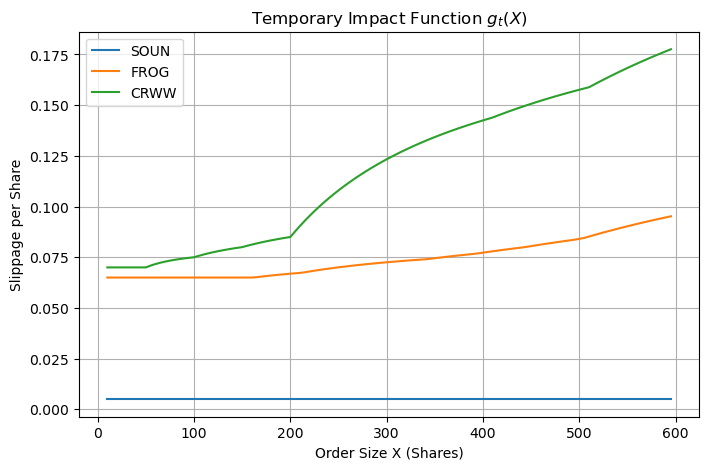

In [82]:
# Fixing an arbitrary single timestamp
sample_soun = soun_clean.iloc[790] 
sample_frog = frog_clean.iloc[500]
sample_crww = crww_clean.iloc[500]


X_grid = np.arange(10, 600, 5)
gt_soun = [compute_temp_impact(sample_soun, X_shares=X) for X in X_grid]
gt_frog = [compute_temp_impact(sample_frog, X_shares=X) for X in X_grid]
gt_crww = [compute_temp_impact(sample_crww, X_shares=X) for X in X_grid]

# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, gt_soun, label='SOUN')
plt.plot(X_grid, gt_frog, label='FROG')
plt.plot(X_grid, gt_crww, label='CRWW')
plt.title("Temporary Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

In [90]:
np.max(gt_soun)

np.float64(0.005000000000000782)

In [93]:
soun_clean.iloc[790]

ts_event                   2025-04-07 13:40:00+00:00
ts_event.1       2025-04-07 13:40:00.004636532+00:00
rtype                                             10
publisher_id                                       2
instrument_id                                  14993
                                ...                 
ask_sz_09                                        750
bid_ct_09                                          1
ask_ct_09                                          4
symbol                                          SOUN
mid_price                                      6.735
Name: 790, Length: 75, dtype: object

The curves for CRWW and FROG behave in a piecewise convex way while the curve of SOUN is almost horizontal everywhere.

The nearly flat gt_soun curve with a maximum value of 0.005 dollars per share for order sizes $ X $ from 10 to 600 shares at the timestamp soun_clean.iloc[790] indicates that the temporary impact function $g_t(X)$ remains constant, suggesting high liquidity and a tight bid-ask spread in the SOUN stock's limit order book (LOB) at that moment on April 7, 2025. 

### Model Fitting
Next, we fit three parametric candidate models and choose the best fit based on their adjusted R-squared, AIC and MSE values. These parametric models include:
- Linear model 
- Power Model (as used by Almgren(2003))
- Quadratic Model

To fit a parametric model to the temporary impact function, we first compute the mean impact across all observations for each order size X. This step is necessary because each trade or timestamp may give a different impact value due to noise and market variability, but we’re ultimately interested in the average behavior, not individual fluctuations. 

Also, taking the mean at each X helps us extract a clean and representative signal from the data, which we can then fit to models like the linear or power function. It also ensures that the fitting process captures the overall structure of the impact curve, rather than chasing noise in the raw data.

In [100]:
true_soun = [soun_clean.apply(lambda row: compute_temp_impact(row, X_shares=X), axis=1).mean() for X in X_grid]
true_frog = [frog_clean.apply(lambda row: compute_temp_impact(row, X_shares=X), axis=1).mean() for X in X_grid]
true_crww = [crww_clean.apply(lambda row: compute_temp_impact(row, X_shares=X), axis=1).mean() for X in X_grid]

In [103]:
print(X_grid.shape)
print(len(true_soun))
print(len(true_frog))
print(len(true_crww))

(118,)
118
118
118


#### Linear Model

We fit a linear model to the temporary impact function and examine how well the model represents the data and how well it might generalize to new data. In particular, we implement $$g_{t}(X) = \beta_{t}x$$

In [178]:
# linear model function
def linear_model(x, beta):
    return beta * x

# Fitting linear model to all 3 stocks using curve_fit from scipy.optimize
beta_soun,_ = curve_fit(linear_model, X_grid, true_soun)
beta_frog,_ = curve_fit(linear_model, X_grid, true_frog)
beta_crww,_ = curve_fit(linear_model, X_grid, true_crww)

# Extrtacting betas from the array
beta_soun = beta_soun[0]
beta_frog = beta_frog[0]
beta_crww = beta_crww[0]

# Linear model predictions
pred_soun = linear_model(X_grid, beta_soun)
pred_frog = linear_model(X_grid, beta_frog)
pred_crww = linear_model(X_grid, beta_crww)

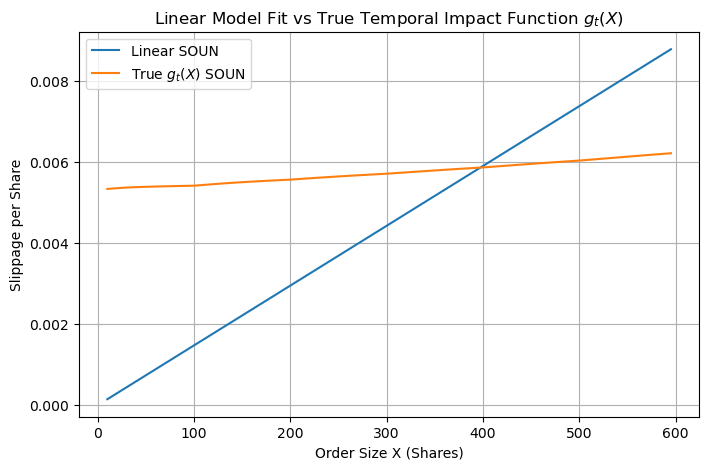

In [179]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, pred_soun, label='Linear SOUN')
plt.plot(X_grid, true_soun, label='True $g_t(X)$ SOUN')
plt.title("Linear Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

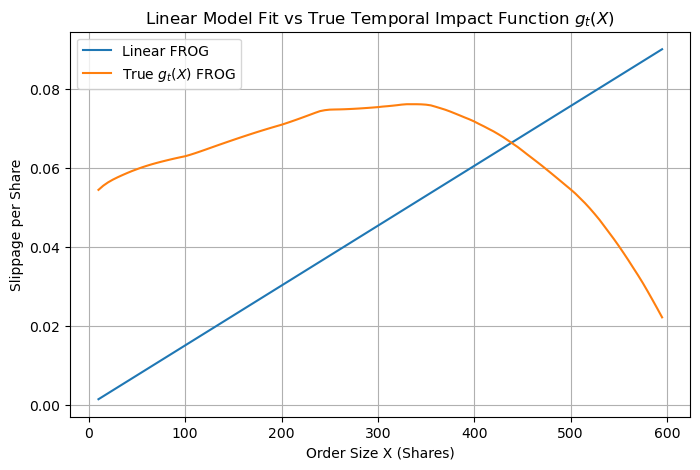

In [180]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, pred_frog, label='Linear FROG')
plt.plot(X_grid, true_frog, label='True $g_t(X)$ FROG')
plt.title("Linear Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

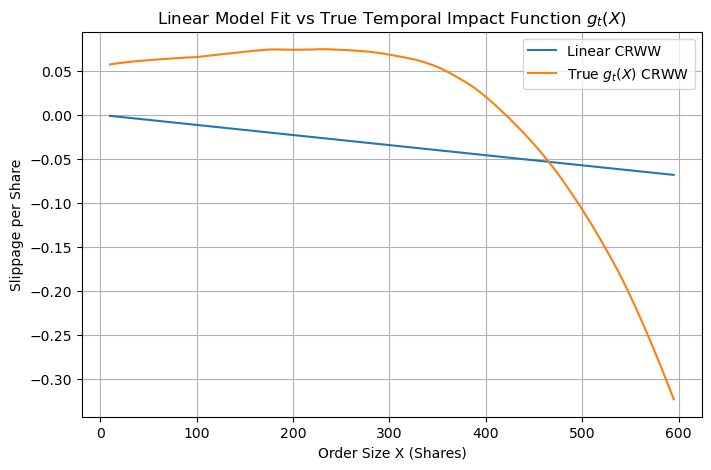

In [181]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, pred_crww, label='Linear CRWW')
plt.plot(X_grid, true_crww, label='True $g_t(X)$ CRWW')
plt.title("Linear Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

Clearly, the linear model fit does not perform very well in modelling the temporary impact function. To understand the model's performance, we compute fit statistics as follows: 

In [212]:
# Residuals
soun_residuals = true_soun - pred_soun
frog_residuals = true_frog - pred_frog
crww_residuals = true_crww - pred_crww

# Mean Squared Errors (MSE)
soun_mse = np.mean(soun_residuals**2)
frog_mse = np.mean(frog_residuals**2)
crww_mse = np.mean(crww_residuals**2)

# R-squared values
soun_sst = np.sum((true_soun - np.mean(true_soun))**2)
soun_ssr = np.sum(soun_residuals**2)
soun_rsq = 1 - soun_ssr / soun_sst

frog_sst = np.sum((true_frog - np.mean(true_frog))**2)
frog_ssr = np.sum(frog_residuals**2)
frog_rsq = 1 - frog_ssr / frog_sst

crww_sst = np.sum((true_crww - np.mean(true_crww))**2)
crww_ssr = np.sum(crww_residuals**2)
crww_rsq = 1 - crww_ssr / crww_sst

# Adjusted R-squared values
N = len(X_grid)
K = 1
soun_adj_rsq = 1 - (soun_ssr/(N - K)) / (soun_sst / (N - 1))
frog_adj_rsq = 1 - (frog_ssr/(N - K)) / (frog_sst / (N - 1))
crww_adj_rsq = 1 - (crww_ssr/(N - K)) / (crww_sst / (N - 1))

# Akaike Information Criterion (AIC)
soun_aic = N * log(soun_ssr / N) + 2*K
frog_aic = N * log(frog_ssr / N) + 2*K
crww_aic = N * log(crww_ssr / N) + 2*K

# Build the DataFrame
fit_statistics = pd.DataFrame({
    'MSE': [soun_mse, frog_mse, crww_mse],
    'R-squared': [soun_rsq, frog_rsq, crww_rsq],
    'Adjusted R-squared': [soun_adj_rsq, frog_adj_rsq, crww_adj_rsq],
    'AIC': [soun_aic, frog_aic, crww_aic]
}, index=['SOUN', 'FROG', 'CRWW'])

fit_statistics = fit_statistics.round(5)

fit_statistics

,MSE,R-squared,Adjusted R-squared,AIC
SOUN,0.00001,-100.11927,-100.11927,-1403.58801
FROG,0.00142,-7.81274,-7.81274,-771.72045
CRWW,0.00958,0.14158,0.14158,-546.45600



- **Mean Squared Error (MSE)**: Measures average squared prediction error. For `SOUN`, MSE is 0.00001 (very low), suggesting small errors, but it rises to 0.00142 for `FROG` and 0.00958 for `CRWW`, indicating larger errors as liquidity decreases. This shows the model struggles with varying impact curves.

- **R-squared**: Indicates variance explained (0 to 1 is good, negative is worse than the mean). `SOUN` has -100.11927 and `FROG` -7.81274, meaning the model fails badly (e.g., `SOUN`'s flat 0.005 trend), while `CRWW`'s 0.14158 shows only 14% variance explained, highlighting poor fit overall.

- **Adjusted R-squared**: Adjusts R-squared for one parameter $\beta$. Matching R-squared (-100.11927 for `SOUN`, -7.81274 for `FROG`, 0.14158 for `CRWW`), it confirms no improvement, reinforcing the model’s inadequacy across stocks.

- **Akaike Information Criterion (AIC)**: Balances fit and complexity (lower is better). Values are -1403.58801 for `SOUN`, -771.72045 for `FROG`, and -546.45600 for `CRWW`, which are high (less negative), indicating the simple model’s poor fit outweighs its low complexity, especially for `SOUN` and `FROG`.

These metrics suggest the linear model is a poor fit, failing to capture the nonlinear, piecewise convex nature of $g_t(X)$. 

#### Residual Plots For Linear Model

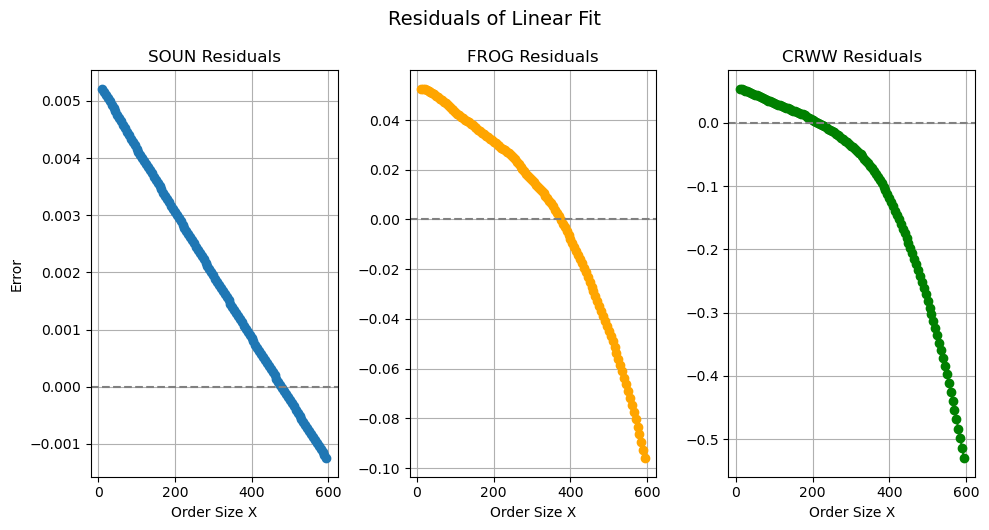

In [191]:
plt.figure(figsize=(10, 5))

# SOUN residuals
plt.subplot(1, 3, 1)
plt.plot(X_grid, soun_residuals, marker='o', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title("SOUN Residuals")
plt.xlabel("Order Size X")
plt.ylabel("Error")
plt.grid(True)

# FROG residuals
plt.subplot(1, 3, 2)
plt.plot(X_grid, frog_residuals, marker='o', label='Residuals', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("FROG Residuals")
plt.xlabel("Order Size X")
plt.grid(True)

# CRWW residuals
plt.subplot(1, 3, 3)
plt.plot(X_grid, crww_residuals, marker='o', label='Residuals', color='green')
plt.axhline(0, color='gray', linestyle='--')
plt.title("CRWW Residuals")
plt.xlabel("Order Size X")
plt.grid(True)

plt.tight_layout()
plt.suptitle("Residuals of Linear Fit", y=1.05, fontsize=14)
plt.show()

#### Convex Power Law Model

We follow the idea used by Almgren (2003) where market impact cost per share is taken to be a power law function of the trading rate, with an arbitrary positive exponent. 

The power law model is given by $$g_{t}(X) = \gamma_{t}x^{\delta_t} \quad \delta_t > 0$$

In [182]:
# power law model function
def power_law(x, gamma, delta):
    return gamma * np.power(x, delta)

# Fitting power law model to all 3 stocks 
param, _ = curve_fit(power_law, X_grid, true_soun)
params,_ = curve_fit(power_law, X_grid, true_frog)
paramss,_ = curve_fit(power_law, X_grid, true_crww)

# Extrtacting betas from the array
gamma_soun = param[0]
delta_soun = param[1]
gamma_frog =  params[0]
delta_frog = params[1]
gamma_crww = paramss[0]
delta_crww = paramss[1]

# Linear model predictions
power_pred_soun = power_law(X_grid, gamma_soun, delta_soun)
power_pred_frog = power_law(X_grid, gamma_frog, delta_frog)
power_pred_crww = power_law(X_grid, gamma_crww, delta_crww)

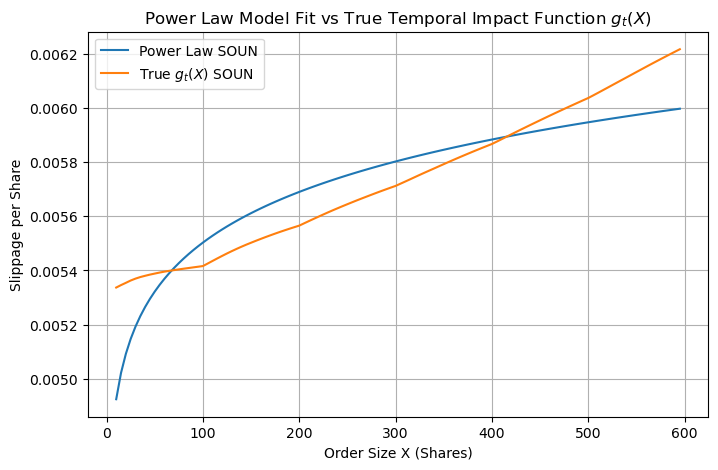

In [183]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, power_pred_soun, label='Power Law SOUN')
plt.plot(X_grid, true_soun, label='True $g_t(X)$ SOUN')
plt.title("Power Law Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

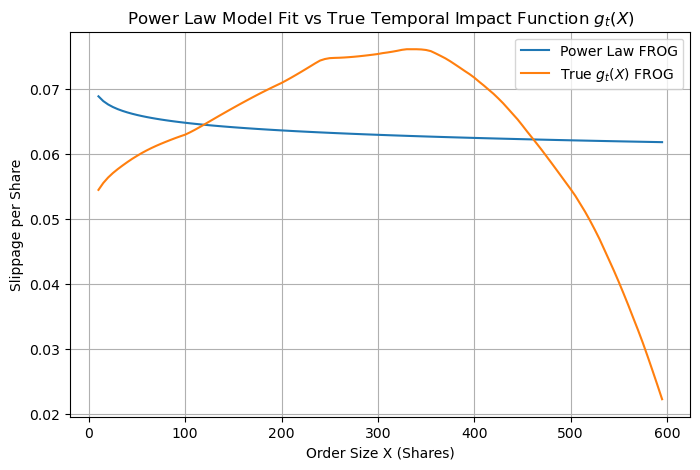

In [184]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, power_pred_frog, label='Power Law FROG')
plt.plot(X_grid, true_frog, label='True $g_t(X)$ FROG')
plt.title("Power Law Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

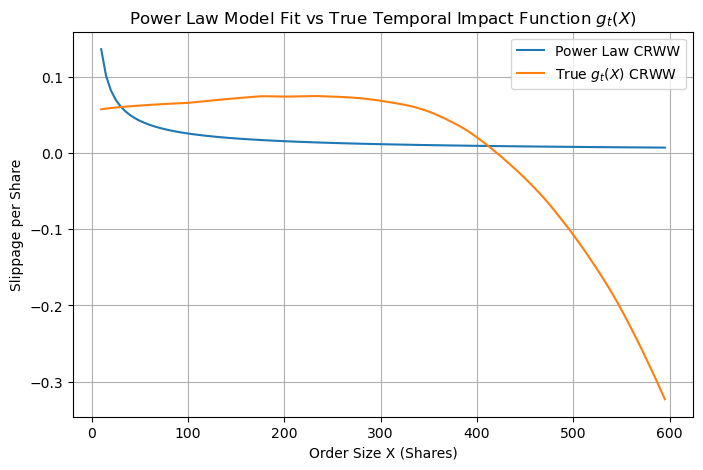

In [185]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, power_pred_crww, label='Power Law CRWW')
plt.plot(X_grid, true_crww, label='True $g_t(X)$ CRWW')
plt.title("Power Law Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

In [192]:
# Residuals
power_soun_residuals = true_soun - power_pred_soun
power_frog_residuals = true_frog - power_pred_frog
power_crww_residuals = true_crww - power_pred_crww

# Mean Squared Errors (MSE)
power_soun_mse = np.mean(power_soun_residuals**2)
power_frog_mse = np.mean(power_frog_residuals**2)
power_crww_mse = np.mean(power_crww_residuals**2)

# R-squared values
power_soun_sst = np.sum((true_soun - np.mean(true_soun))**2)
power_soun_ssr = np.sum(power_soun_residuals**2)
power_soun_rsq = 1 - power_soun_ssr / power_soun_sst

power_frog_sst = np.sum((true_frog - np.mean(true_frog))**2)
power_frog_ssr = np.sum(power_frog_residuals**2)
power_frog_rsq = 1 - power_frog_ssr / power_frog_sst

power_crww_sst = np.sum((true_crww - np.mean(true_crww))**2)
power_crww_ssr = np.sum(power_crww_residuals**2)
power_crww_rsq = 1 - power_crww_ssr / power_crww_sst

# Adjusted R-squared values
N = len(X_grid)
K = 2
pow_soun_adj_rsq = 1 - (power_soun_ssr/(N - K)) / (power_soun_sst / (N - 1))
pow_frog_adj_rsq = 1 - (power_frog_ssr/(N - K)) / (power_frog_sst / (N - 1))
pow_crww_adj_rsq = 1 - (power_crww_ssr/(N - K)) / (power_crww_sst / (N - 1))

# Akaike Information Criterion (AIC)
pow_soun_aic = N * log(power_soun_ssr / N) + 2*K
pow_frog_aic = N * log(power_frog_ssr / N) + 2*K
pow_crww_aic = N * log(power_crww_ssr / N) + 2*K

# Build the DataFrame
pow_fit_statistics = pd.DataFrame({
    'MSE': [power_soun_mse, power_frog_mse, power_crww_mse],
    'R-squared': [power_soun_rsq, power_frog_rsq, power_crww_rsq],
    'Adjusted R-squared': [pow_soun_adj_rsq, pow_frog_adj_rsq, pow_crww_adj_rsq],
    'AIC': [pow_soun_aic, pow_frog_aic, pow_crww_aic]
}, index=['SOUN', 'FROG', 'CRWW'])

pow_fit_statistics = pow_fit_statistics.round(5)

pow_fit_statistics

,MSE,R-squared,Adjusted R-squared,AIC
SOUN,0.00000,0.79879,0.79705,-2135.51196
FROG,0.00016,0.01550,0.00702,-1028.35549
CRWW,0.01050,0.05957,0.05146,-533.68907


We evaluate the power-law model using MSE, R-squared, Adjusted R-squared, and AIC for `SOUN`, `FROG`, and `CRWW` as follows:

- **Mean Squared Error (MSE)**: Measures average squared prediction error. For `SOUN`, MSE is 0.00000 (excellent), improving to 0.00016 for `FROG`, but rising to 0.01050 for `CRWW`, suggesting good fit for high-liquidity stocks but larger errors where impact curves vary.

- **R-squared**: Indicates variance explained (0 to 1 is good). `SOUN` has 0.79879 (79.88% explained), showing a strong fit, but `FROG` (0.01550) and `CRWW` (0.05957) have very low values, indicating the model captures little variance for these stocks, likely due to mismatched curvature.

- **Adjusted R-squared**: Adjusts R-squared for two parameters ($\gamma, \delta$). It’s 0.79705 for `SOUN`, 0.00702 for `FROG`, and 0.05146 for `CRWW`, slightly lower than R-squared, confirming a decent fit for `SOUN` but poor adjustment for `FROG` and `CRWW` due to added complexity.

- **Akaike Information Criterion (AIC)**: Balances fit and complexity (lower is better). Values are -2135.51196 for `SOUN`, -1028.35549 for `FROG`, and -533.68907 for `CRWW`, which are moderate, reflecting a better fit than linear for `SOUN` but declining performance for `FROG` and `CRWW`.

These metrics indicate the power-law model fits well for `SOUN`’s high-liquidity flat trend but struggles with the nonlinear, piecewise convex nature of `FROG` and `CRWW`.

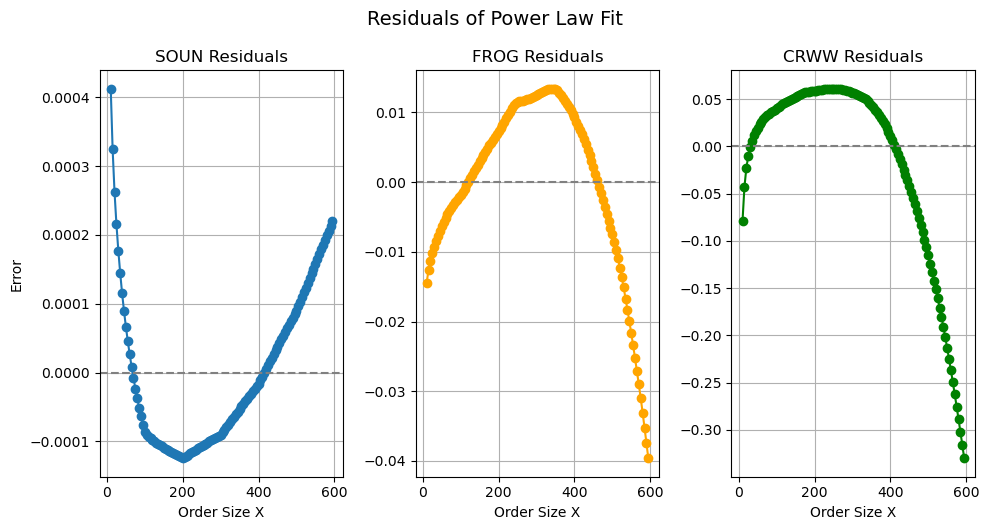

In [210]:
plt.figure(figsize=(10, 5))

# SOUN residuals
plt.subplot(1, 3, 1)
plt.plot(X_grid, power_soun_residuals, marker='o', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title("SOUN Residuals")
plt.xlabel("Order Size X")
plt.ylabel("Error")
plt.grid(True)

# FROG residuals
plt.subplot(1, 3, 2)
plt.plot(X_grid, power_frog_residuals, marker='o', label='Residuals', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("FROG Residuals")
plt.xlabel("Order Size X")
plt.grid(True)

# CRWW residuals
plt.subplot(1, 3, 3)
plt.plot(X_grid, power_crww_residuals, marker='o', label='Residuals', color='green')
plt.axhline(0, color='gray', linestyle='--')
plt.title("CRWW Residuals")
plt.xlabel("Order Size X")
plt.grid(True)

plt.tight_layout()
plt.suptitle("Residuals of Power Law Fit", y=1.05, fontsize=14)
plt.show()

Since the residuals are exhibitting a U shape, it suggests that a quadratic fit would be an ideal fit.

#### Quadratic Model

Next, we implement and evaluate the quadratic fit for modeling the temporary impact function such that
$$g_{t}(X) = a_{t}x^2 + b_{t}x + c_t $$
We shall follow the same structure as for the power law and linear fit.

In [204]:
# linear model function
def quadratic_model(x, a,b,c):
    return a * x**2 + b * x + c

# Fitting quadratic model to all 3 stocks 
qparam,_ = curve_fit(quadratic_model, X_grid, true_soun)
qparams,_ = curve_fit(quadratic_model, X_grid, true_frog)
qparamss,_ = curve_fit(quadratic_model, X_grid, true_crww)

# Extrtacting parameters from the array
a_soun = qparam[0]
b_soun = qparam[1]
c_soun = qparam[2]
a_frog =  qparams[0]
b_frog = qparams[1]
c_frog = qparams[2]
a_crww = qparamss[0]
b_crww = qparamss[1]
c_crww = qparamss[2]

# Linear model predictions
q_pred_soun = quadratic_model(X_grid, a_soun, b_soun, c_soun)
q_pred_frog = quadratic_model(X_grid, a_frog, b_frog, c_frog)
q_pred_crww = quadratic_model(X_grid, a_crww, b_crww, c_crww)

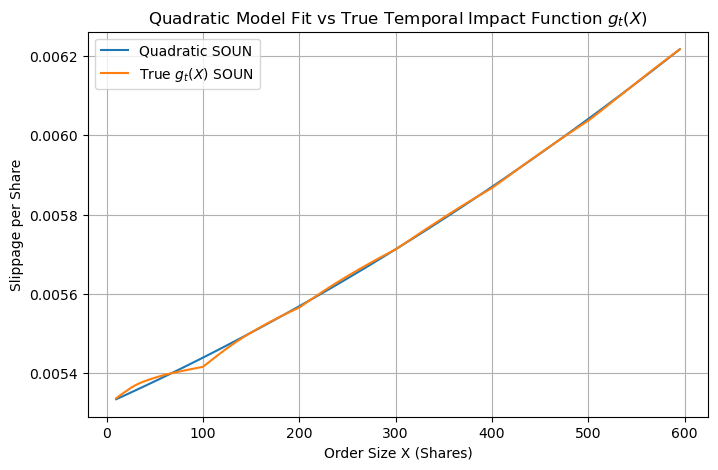

In [205]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, q_pred_soun, label='Quadratic SOUN')
plt.plot(X_grid, true_soun, label='True $g_t(X)$ SOUN')
plt.title("Quadratic Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

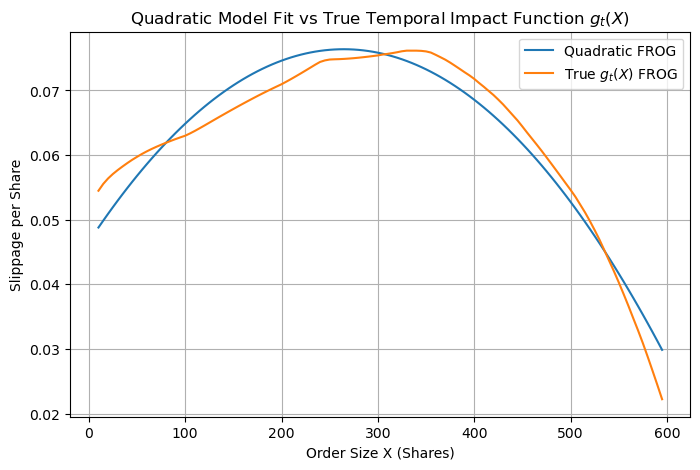

In [207]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, q_pred_frog, label='Quadratic FROG')
plt.plot(X_grid, true_frog, label='True $g_t(X)$ FROG')
plt.title("Quadratic Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

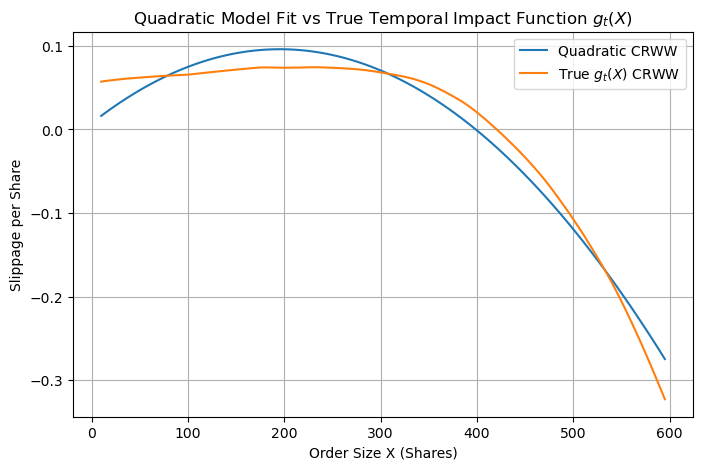

In [208]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(X_grid, q_pred_crww, label='Quadratic CRWW')
plt.plot(X_grid, true_crww, label='True $g_t(X)$ CRWW')
plt.title("Quadratic Model Fit vs True Temporal Impact Function $g_t(X)$")
plt.xlabel("Order Size X (Shares)")
plt.ylabel("Slippage per Share")
plt.grid(True)
plt.legend()
plt.show()

For all three stocks, we observe from the plots that the quadratic model seems to fit well. To validate this claim, we perform some model agnostics by measuring the fit statistics using the same metrics used in the previous cases; R-squared, Adjusted R-squared and AIC.

In [209]:
# Residuals
q_soun_residuals = true_soun - q_pred_soun
q_frog_residuals = true_frog - q_pred_frog
q_crww_residuals = true_crww - q_pred_crww

# Mean Squared Errors (MSE)
q_soun_mse = np.mean(q_soun_residuals**2)
q_frog_mse = np.mean(q_frog_residuals**2)
q_crww_mse = np.mean(q_crww_residuals**2)

# R-squared values
q_soun_sst = np.sum((true_soun - np.mean(true_soun))**2)
q_soun_ssr = np.sum(q_soun_residuals**2)
q_soun_rsq = 1 - q_soun_ssr / q_soun_sst

q_frog_sst = np.sum((true_frog - np.mean(true_frog))**2)
q_frog_ssr = np.sum(q_frog_residuals**2)
q_frog_rsq = 1 - q_frog_ssr / q_frog_sst

q_crww_sst = np.sum((true_crww - np.mean(true_crww))**2)
q_crww_ssr = np.sum(q_crww_residuals**2)
q_crww_rsq = 1 - q_crww_ssr / q_crww_sst

# Adjusted R-squared values
N = len(X_grid)
K = 3
q_soun_adj_rsq = 1 - (q_soun_ssr/(N - K)) / (q_soun_sst / (N - 1))
q_frog_adj_rsq = 1 - (q_frog_ssr/(N - K)) / (q_frog_sst / (N - 1))
q_crww_adj_rsq = 1 - (q_crww_ssr/(N - K)) / (q_crww_sst / (N - 1))

# Akaike Information Criterion (AIC)
q_soun_aic = N * log(q_soun_ssr / N) + 2*K
q_frog_aic = N * log(q_frog_ssr / N) + 2*K
q_crww_aic = N * log(q_crww_ssr / N) + 2*K

# Build the DataFrame
q_fit_statistics = pd.DataFrame({
    'MSE': [q_soun_mse, q_frog_mse, q_crww_mse],
    'R-squared': [q_soun_rsq, q_frog_rsq, q_crww_rsq],
    'Adjusted R-squared': [q_soun_adj_rsq, q_frog_adj_rsq, q_crww_adj_rsq],
    'AIC': [q_soun_aic, q_frog_aic, q_crww_aic]
}, index=['SOUN', 'FROG', 'CRWW'])

q_fit_statistics = q_fit_statistics.round(5)

q_fit_statistics

,MSE,R-squared,Adjusted R-squared,AIC
SOUN,0.00000,0.99949,0.99948,-2838.53357
FROG,0.00001,0.94564,0.94469,-1368.13391
CRWW,0.00035,0.96869,0.96815,-933.17931


The results clearly show that the quadratic model fits the temporary impact function extremely well across all three stocks.

SOUN shows an almost perfect fit, with $R^2 = 0.99949$ and a near-zero MSE. This suggests that the model captures virtually all the variation in slippage across order sizes.

For FROG and CRWW, the fit is still very strong, with $R^2$ values of 0.94564 and 0.96869 respectively. This supports the presence of a nonlinear U-shaped structure in the data, which the quadratic model handles well.

The AIC values are significantly lower than those from both the linear and power-law models, confirming that the quadratic model provides a better tradeoff between goodness-of-fit and model complexity.

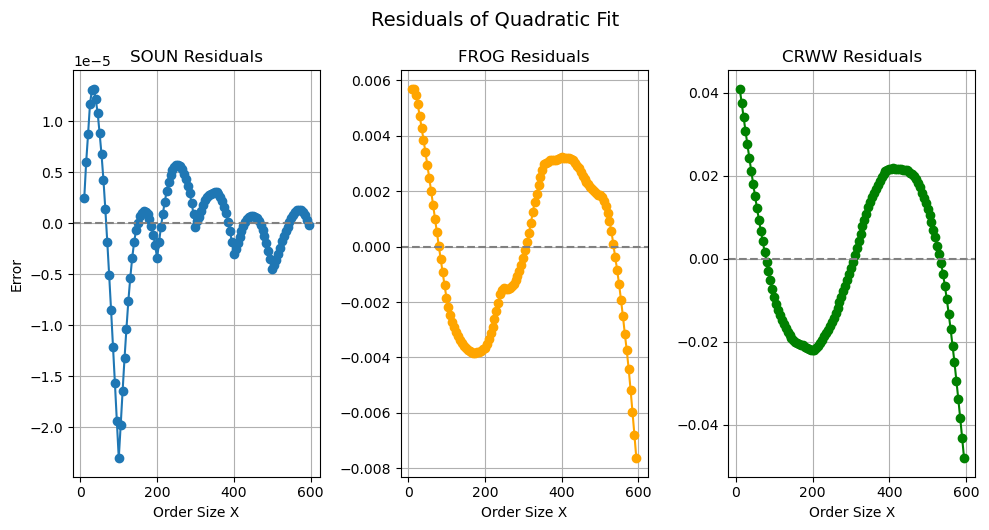

In [211]:
plt.figure(figsize=(10, 5))

# SOUN residuals
plt.subplot(1, 3, 1)
plt.plot(X_grid, q_soun_residuals, marker='o', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title("SOUN Residuals")
plt.xlabel("Order Size X")
plt.ylabel("Error")
plt.grid(True)

# FROG residuals
plt.subplot(1, 3, 2)
plt.plot(X_grid, q_frog_residuals, marker='o', label='Residuals', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("FROG Residuals")
plt.xlabel("Order Size X")
plt.grid(True)

# CRWW residuals
plt.subplot(1, 3, 3)
plt.plot(X_grid, q_crww_residuals, marker='o', label='Residuals', color='green')
plt.axhline(0, color='gray', linestyle='--')
plt.title("CRWW Residuals")
plt.xlabel("Order Size X")
plt.grid(True)

plt.tight_layout()
plt.suptitle("Residuals of Quadratic Fit", y=1.05, fontsize=14)
plt.show()

While the quadratic model fits the temporary impact function very well overall, the residual plot shows a mild wave-like pattern. This may reflect discrete market microstructure effects not fully captured by a smooth functional form. Nonetheless, the model’s predictive performance remains excellent.

### Recommendation

The linear model fails to capture the curvature observed in the empirical temporary impact function, consistently underestimating or overestimating slippage at different order sizes. This results in poor fit metrics and visibly systematic residuals.

The power model captured fairly the dynamics observed in the data. In particular, it performed very well on only the SOUN data and badly on both FROG and CRWW.

In contrast, the quadratic model effectively reflects the nonlinear behavior of slippage, achieving excellent fit statistics across all three stocks. We therefore recommend the quadratic model as the preferred specification for modeling the temporary market impact function.